In [52]:
import pandas as pd
import numpy as np
import pymc as pm
import plotly_express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
# import preliz as pz
# import arviz as az

# Visualising Priors

In [113]:
def draw_samples_from_prior(dist: pm.Distribution, num_samples: int = 10_000,
                            seed=None, **kwargs) -> np.ndarray:
    """
    Draws samples from the prior distribution of a given PyMC distribution.

    This function creates a PyMC model with a single variable, drawn from the specified
    distribution, and then samples from the prior of this distribution.

    Parameters
    ----------
    dist : pm.Distribution
        The PyMC distribution from which to draw samples.
    num_samples : int, optional
        The number of samples to draw from the prior distribution. Default is 10,000.
    seed : int or None, optional
        The seed for the random number generator to ensure reproducibility. If None, 
        the results will vary between runs. Default is None.
    **kwargs
        Additional keyword arguments to pass to the distribution constructor.
        e.g. sigma for Normal, alpha and beta for Beta.
        See PyMC Distributions for more info: https://www.pymc.io/projects/docs/en/stable/api/distributions.html

    Returns
    -------
    np.ndarray
        An array of samples drawn from the specified prior distribution.
    """
    with pm.Model():

        # Define a variable with the given distribution
        my_dist = dist(name = "my_dist", **kwargs)
        
        # Sample from the prior distribution of the model
        draws = pm.draw(my_dist, draws=num_samples, random_seed=seed)
        
    # Return the drawn samples
    return draws


In [141]:
def plot_prior_distribution(draws, nbins=100, opacity=0.2, title="Prior Distribution - Visualised"):
    """
    Plots samples of a prior distribution as a histogram with a KDE (Kernel Density Estimate) overlay
    and a violin plot along the top too with quartile values.
    
    Parameters:
    - draws: numpy array of samples from prior distribution.
    - nbins: int, the number of bins for the histogram.
    - opacity: float, the opacity level for the histogram bars.
    - title: str, the title of the plot.
    """
    # Create the histogram using Plotly Express
    fig = px.histogram(draws, x=draws, nbins=nbins, title=title, 
                       labels={"x": "Value"}, histnorm='probability density', opacity=opacity,
                       marginal="violin", color_discrete_sequence=['#0047AB'])
    
    # Compute the KDE
    kde = gaussian_kde(draws)
    x_range = np.linspace(min(draws), max(draws), 500)
    kde_values = kde(x_range)
    
    # Add the KDE plot to the histogram figure
    fig.add_trace(go.Scatter(x=x_range, y=kde_values, mode='lines', name='KDE', line_color="#5D3FD3"))

    # Calculate buffer for x-axis (e.g., 5% of the range)
    buffer = (max(draws) - min(draws)) * 0.01
    x_min, x_max = min(draws) - buffer, max(draws) + buffer
    
    # Customize the layout
    fig.update_layout(xaxis_title='Value of Prior', 
                      yaxis_title='Density',
                      xaxis_range=[x_min, x_max] # Set the range of the x-axis
                     )  
    
    # Show the plot
    fig.show()


In [129]:
# draws = draw_samples_from_prior(pm.Beta, alpha=1, beta=1)
draws = draw_samples_from_prior(dist=pm.Uniform, num_samples=10000, lower=1, upper=2)

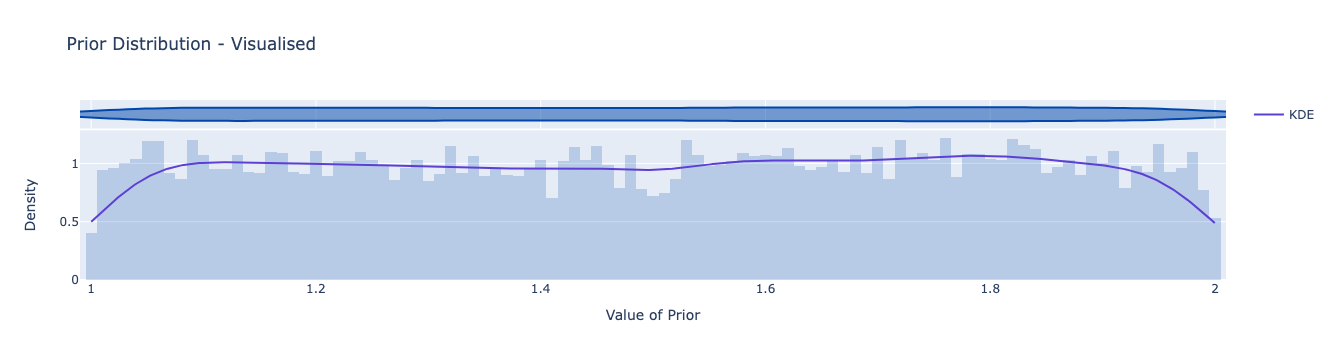

In [142]:
plot_prior_distribution(draws)

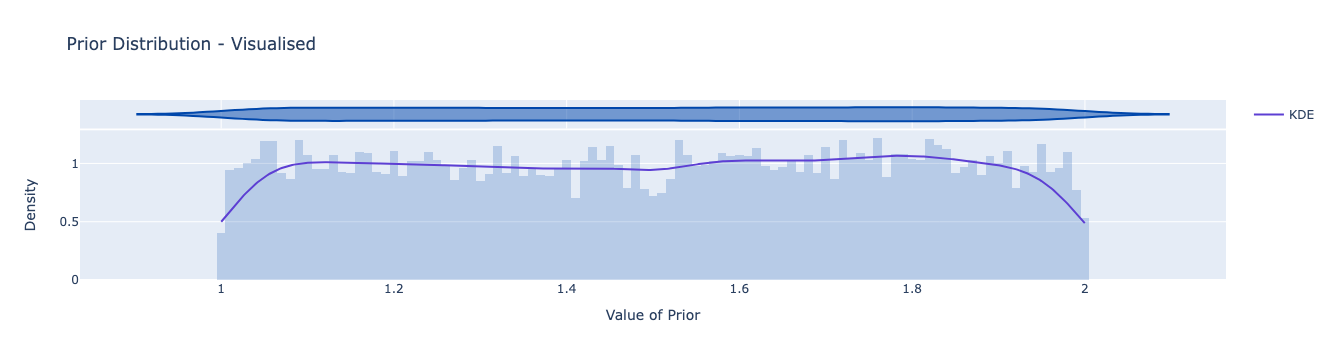

In [134]:
plot_prior_distribution(draws)

# Eliciting Priors

In [3]:
MASS = 0.95
LOWER = 0.1
UPPER = 3
constrained_priors = pm.find_constrained_prior(
    pm.Gamma, lower=LOWER, upper=UPPER, mass=MASS, init_guess=dict(alpha=1, beta=1)
)

In [4]:
constrained_priors

{'alpha': 1.8470694064085313, 'beta': 1.6875496099757592}

In [56]:
with pm.Model() as my_super_model:
    my_beautiful_var = pm.Gamma("my_beautiful_var", **constrained_priors)

In [57]:
draws = pm.draw(my_beautiful_var, draws=10_000)

In [58]:
draws

array([0.50181517, 2.22743758, 0.96169272, ..., 2.08727763, 1.86209152,
       1.19686837])

In [31]:
q = pm.Gamma.dist(**constrained_priors, shape=100)

In [32]:
q.

gamma_rv{0, (0, 0), floatX, False}.out

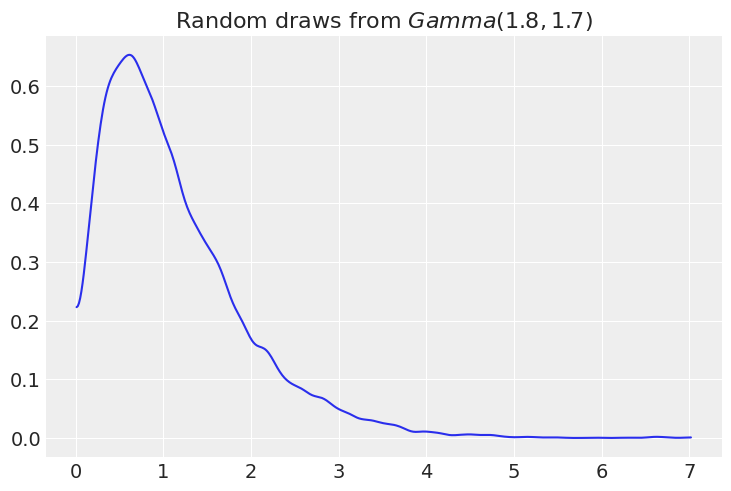

In [17]:
az.style.use("arviz-darkgrid")
ax = az.plot_dist(draws)
ax.set_title(
    f"Random draws from $Gamma({round(constrained_priors['alpha'], 1)}, {round(constrained_priors['beta'], 1)})$"
);

In [19]:
import seaborn as sns

<Axes: ylabel='Density'>

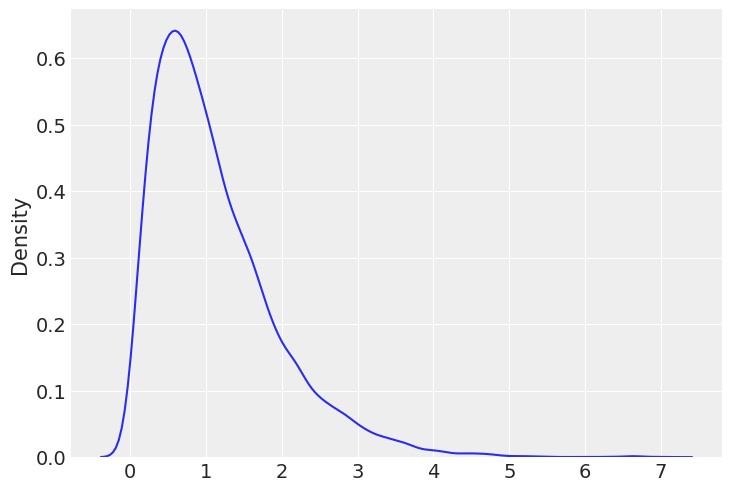

In [21]:
sns.kdeplot(draws)